# <span style='font-family:"Times New Roman"'> <span styel=''>**TP53 MUT/LOH STATUS**

*Emile Cohen*
    
 *May 2020*

**Goal:** In this notebook we compare WGD and Non-WGD Cohort in terms of Tp53 mut/LOH Status.

---

In [11]:
%run -i '../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec
import pickle

data_path = '../../../data/'
data_wgd = data_path + 'impact-facets-tp53/processed/wgd/'
data_no_wgd = data_path + 'impact-facets-tp53/processed/no_wgd/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

In [38]:
def get_statistics(df: pd.DataFrame, group:str, metrics: str, group_list: list):
    group_1 = df[df[group] == group_list[0]][metrics]
    group_2 = df[df[group] == group_list[1]][metrics]

    median_1 = group_1.median()
    median_2 = group_2.median()

    statistic, p_value = ranksums(group_1.dropna().values,group_2.dropna().values)
    
    results = [['', 'size', metrics],
               [group_list[0], group_1.shape[0], median_1],
               [group_list[1], group_2.shape[0], median_2],
               ['', 'Statistics', 'p-value'],
               ['', statistic, p_value]]
    
    return pd.DataFrame(results)

In [12]:
# Load the masters
master_no_wgd = pd.read_pickle(data_path + 'impact-facets-tp53/processed/no_wgd/master_no_wgd.pkl')
master_wgd = pd.read_pickle(data_path + 'impact-facets-tp53/processed/wgd/master_wgd.pkl')

In [40]:
!pwd

/Users/cohene/repos/mskimpact_tp53_exploration/analysis/exploratory_analysis/wgd_study


# Master CutOff
We have to cutoff the master in order to clean subgroups:
* 1_WILD_TYPE has a low purity distribution so we have to put a threshold
* We need to clesan 1_WILD_TYPE to be sure that there are TP53 residuals


In [16]:
# The following function allows to filter the non_WGD cohort, the 1_WT subgroup
def non_wgd_load_and_cut(path):
    master_no_wgd = pd.read_pickle(path)
    master_cutoff = master_no_wgd
    master_cutoff.drop(master_cutoff[master_cutoff['tp53_group'] == '1_WILD_TYPE'][master_cutoff['purity'] <= 0.3][master_cutoff['tp53_vaf_1'] <= 0.15].index , inplace=True)
    master_cutoff.drop(master_cutoff[master_cutoff['tp53_group']=='1_WILD_TYPE'][master_cutoff['tp53_cn_state']=='DIPLOID'][master_cutoff['tp53_vaf_1']>0.6].index, inplace=True)
    master_cutoff.drop(master_cutoff[master_cutoff['tp53_group']=='1_WILD_TYPE'][master_cutoff['tp53_res_1']<0.5].index, inplace=True)

    return master_cutoff

In [17]:
master = non_wgd_load_and_cut(data_path + 'impact-facets-tp53/processed/no_wgd/master_no_wgd.pkl')

# Plot mutations LOH

## Non WGD Cohort

,NO LOH,LOH
tp53_count,,
0,7662.0,2671.0
1,530.0,4074.0
>=2,429.0,149.0


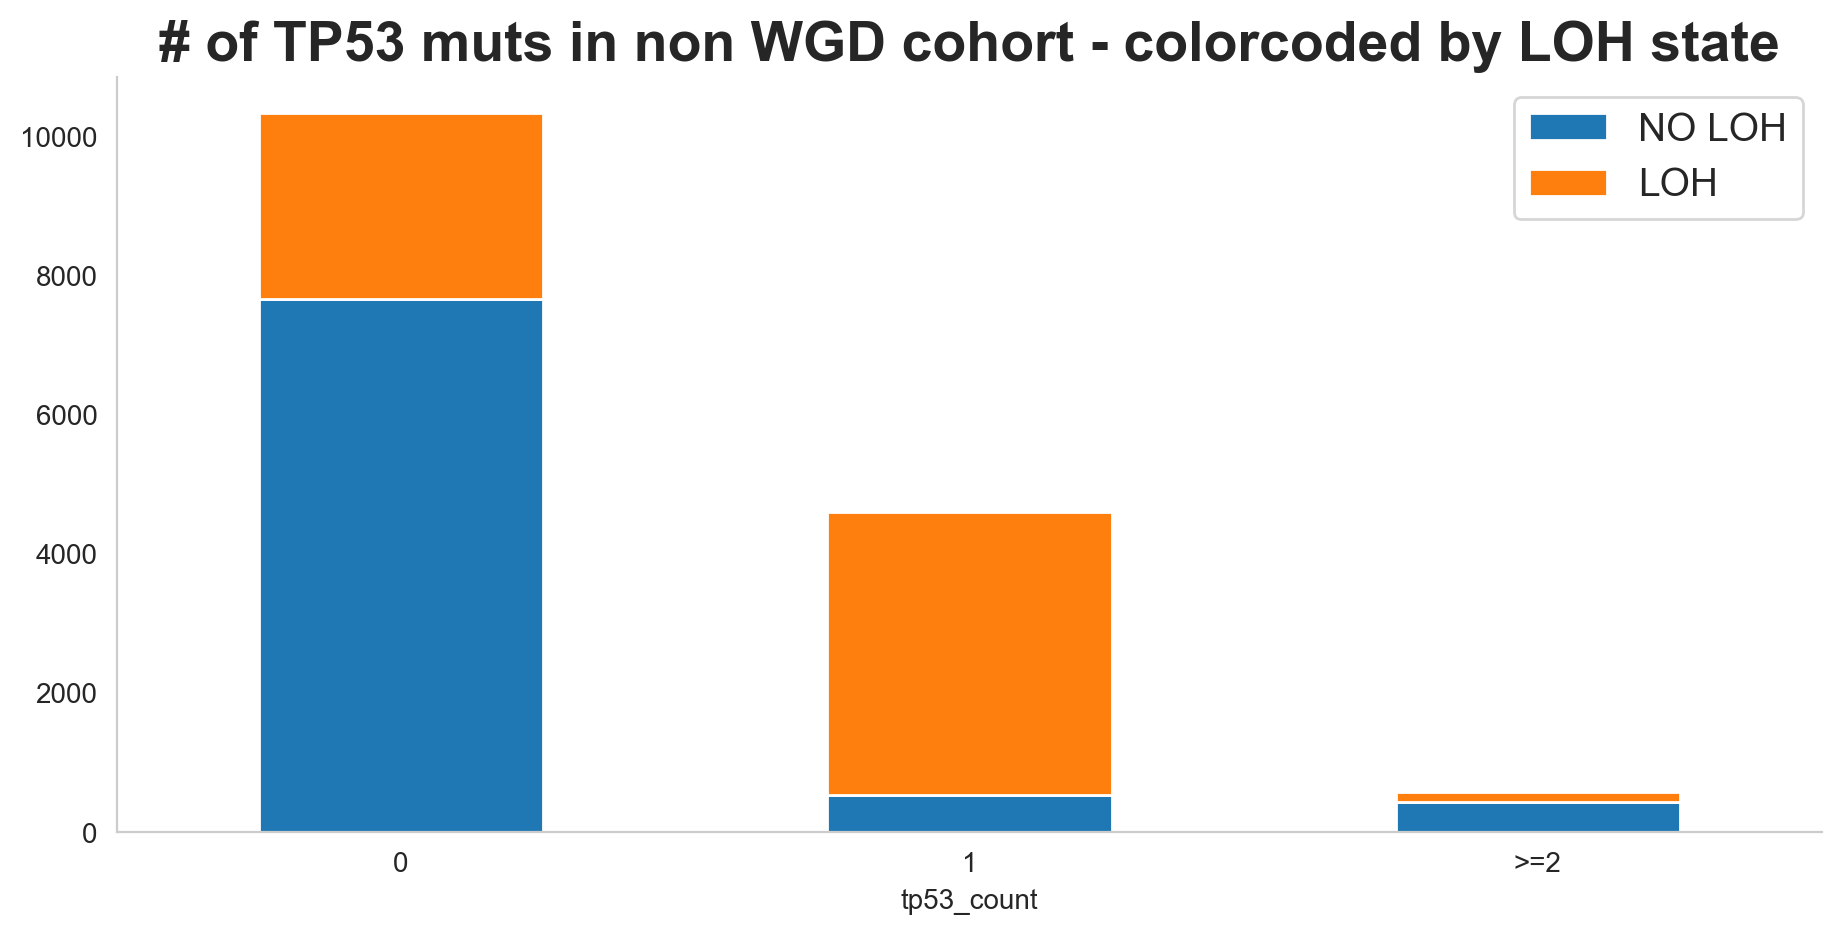

In [111]:
# First we need to groupby our cohort_wgd file to have the size of the different groups
loh_tp53count = pd.DataFrame(master[['tp53_count', 'tp53_loh_status']].groupby(['tp53_count', 'tp53_loh_status']).size()).unstack()
loh_tp53count = loh_tp53count.fillna(0)
loh_tp53count.columns=['NO LOH', 'LOH']
loh_tp53count.loc['>=2'] = [loh_tp53count['NO LOH'][2:].sum(),loh_tp53count['LOH'][2:].sum()]
loh_tp53count = loh_tp53count.drop([2,3,4,5],axis=0)
display(loh_tp53count)

sns.set_style("whitegrid", {'grid.color': '1.'})
fig = plt.figure(figsize=(11,5))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
h = loh_tp53count.plot(kind = 'bar', stacked=True, ax=ax)
ax.set_xticklabels(['0', '1','>=2'], rotation=0)
ax.legend(['NO LOH', 'LOH'], fontsize=14)
ax.set_title('# of TP53 muts in non WGD cohort - colorcoded by LOH state',weight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

,CNLOH,LOSS,HOMDEL,NO LOH
tp53_count,,,,
0,144.0,2431.0,96.0,7662.0
1,692.0,3346.0,36.0,530.0
>=2,23.0,119.0,7.0,429.0


,AMP,AMP (BALANCED),CNLOH,CNLOH & GAIN,DIPLOID,GAIN,HETLOSS,HOMDEL,TETRAPLOID,LOSS,NO LOH
tp53_count,,,,,,,,,,,
0,10.0,2.0,144.0,10.0,7385.0,233.0,2431.0,96.0,32.0,2431.0,7662.0
1,1.0,0.0,692.0,35.0,496.0,33.0,3346.0,36.0,0.0,3346.0,530.0
>=2,0.0,1.0,23.0,1.0,411.0,15.0,119.0,7.0,2.0,119.0,429.0


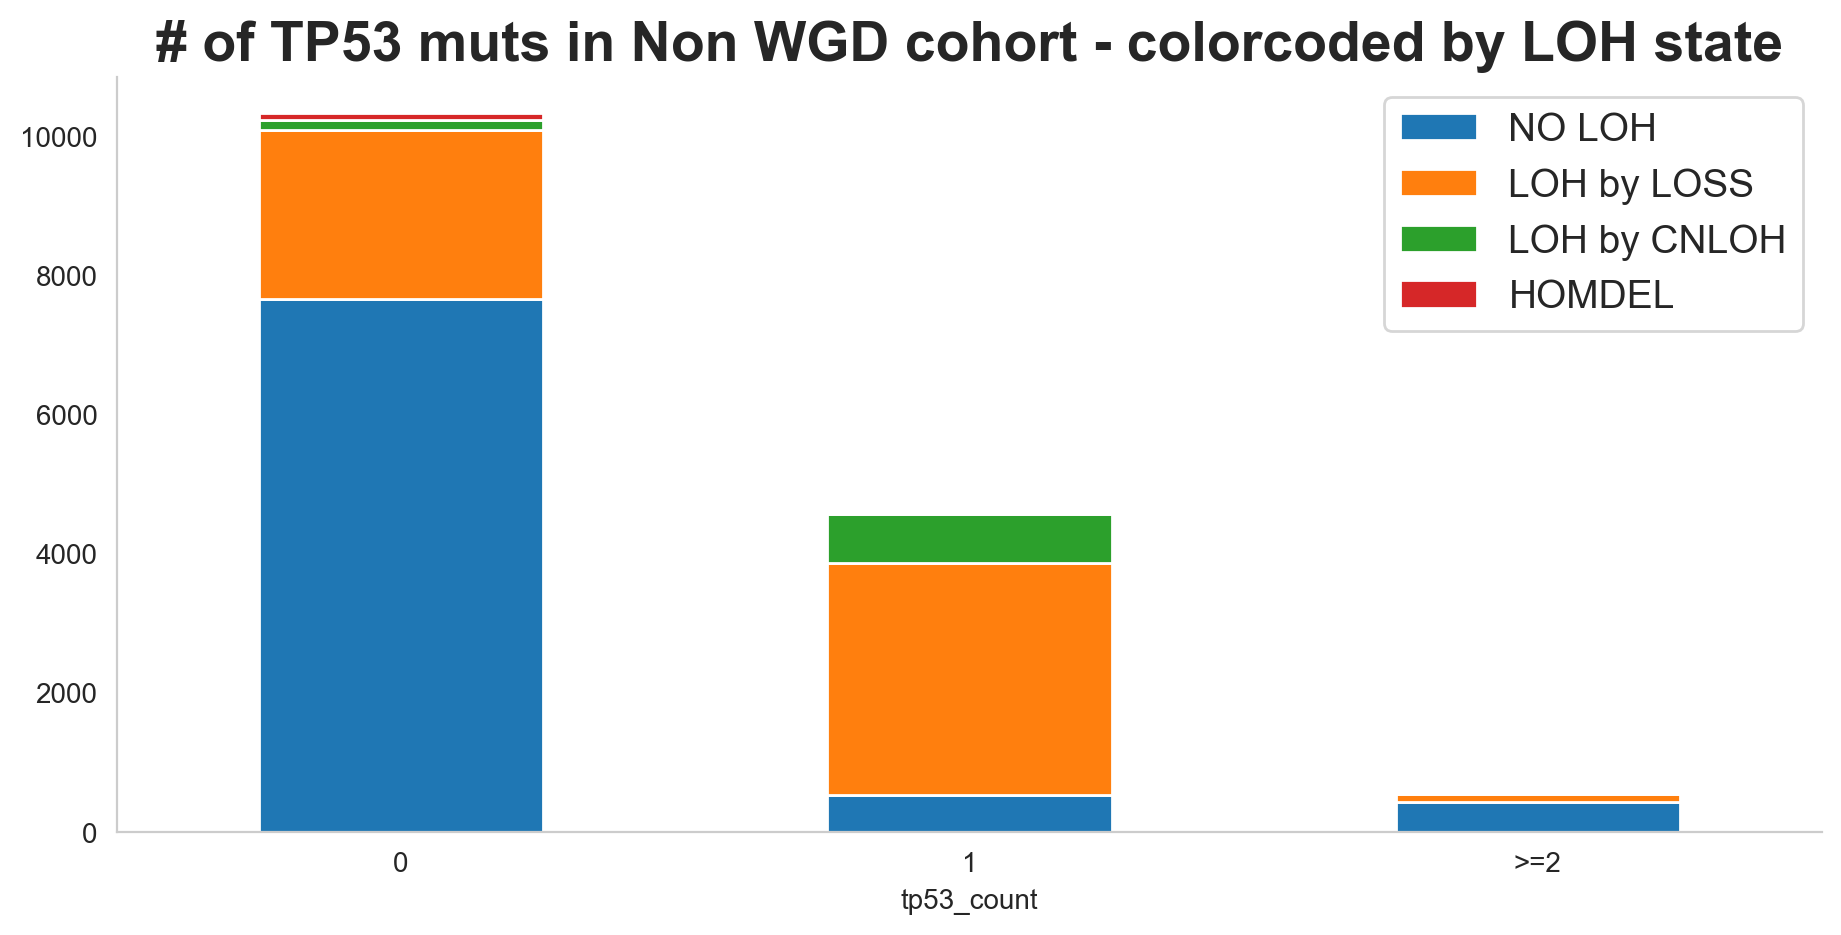

In [113]:
loh_tp53count = pd.DataFrame(master[['tp53_count', 'tp53_cn_state']].groupby(['tp53_count', 'tp53_cn_state']).size()).unstack()
loh_tp53count.columns = ['AMP', 'AMP (BALANCED)', 'CNLOH', 'CNLOH & GAIN', 'DIPLOID', 'GAIN', 'HETLOSS', 'HOMDEL', 'TETRAPLOID']
loh_tp53count = loh_tp53count.fillna(0)

loh_tp53count['CNLOH'] = loh_tp53count[['CNLOH', 'CNLOH & GAIN']].sum(axis=1)
loh_tp53count['LOSS'] = loh_tp53count[['HETLOSS']].sum(axis=1)
loh_tp53count['HOMDEL'] = loh_tp53count[['HOMDEL']].sum(axis=1)
loh_tp53count['NO LOH'] = loh_tp53count[['AMP', 'AMP (BALANCED)', 'DIPLOID', 'GAIN', 'TETRAPLOID']].sum(axis=1)
loh_tp53count.loc['>=2'] = loh_tp53count[2:].sum()
loh_tp53count = loh_tp53count.drop([2,3,4,5],axis=0)

display(loh_tp53count[['CNLOH', 'LOSS', 'HOMDEL', 'NO LOH']])


sns.set_style("whitegrid", {'grid.color': '1.'})
fig = plt.figure(figsize=(11,5))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
h = loh_tp53count[[ 'NO LOH','LOSS', 'CNLOH', 'HOMDEL']].plot(kind = 'bar', stacked=True, ax=ax)
ax.set_xticklabels(['0', '1','>=2'], rotation=0)
ax.legend(['NO LOH', 'LOH by LOSS', 'LOH by CNLOH', 'HOMDEL'], fontsize=14)
ax.set_title('# of TP53 muts in Non WGD cohort - colorcoded by LOH state',weight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

loh_tp53count

## WGD Cohort

,NO LOH,LOH
tp53_count,,
0,1294.0,845.0
1,235.0,3738.0
>=2,179.0,76.0


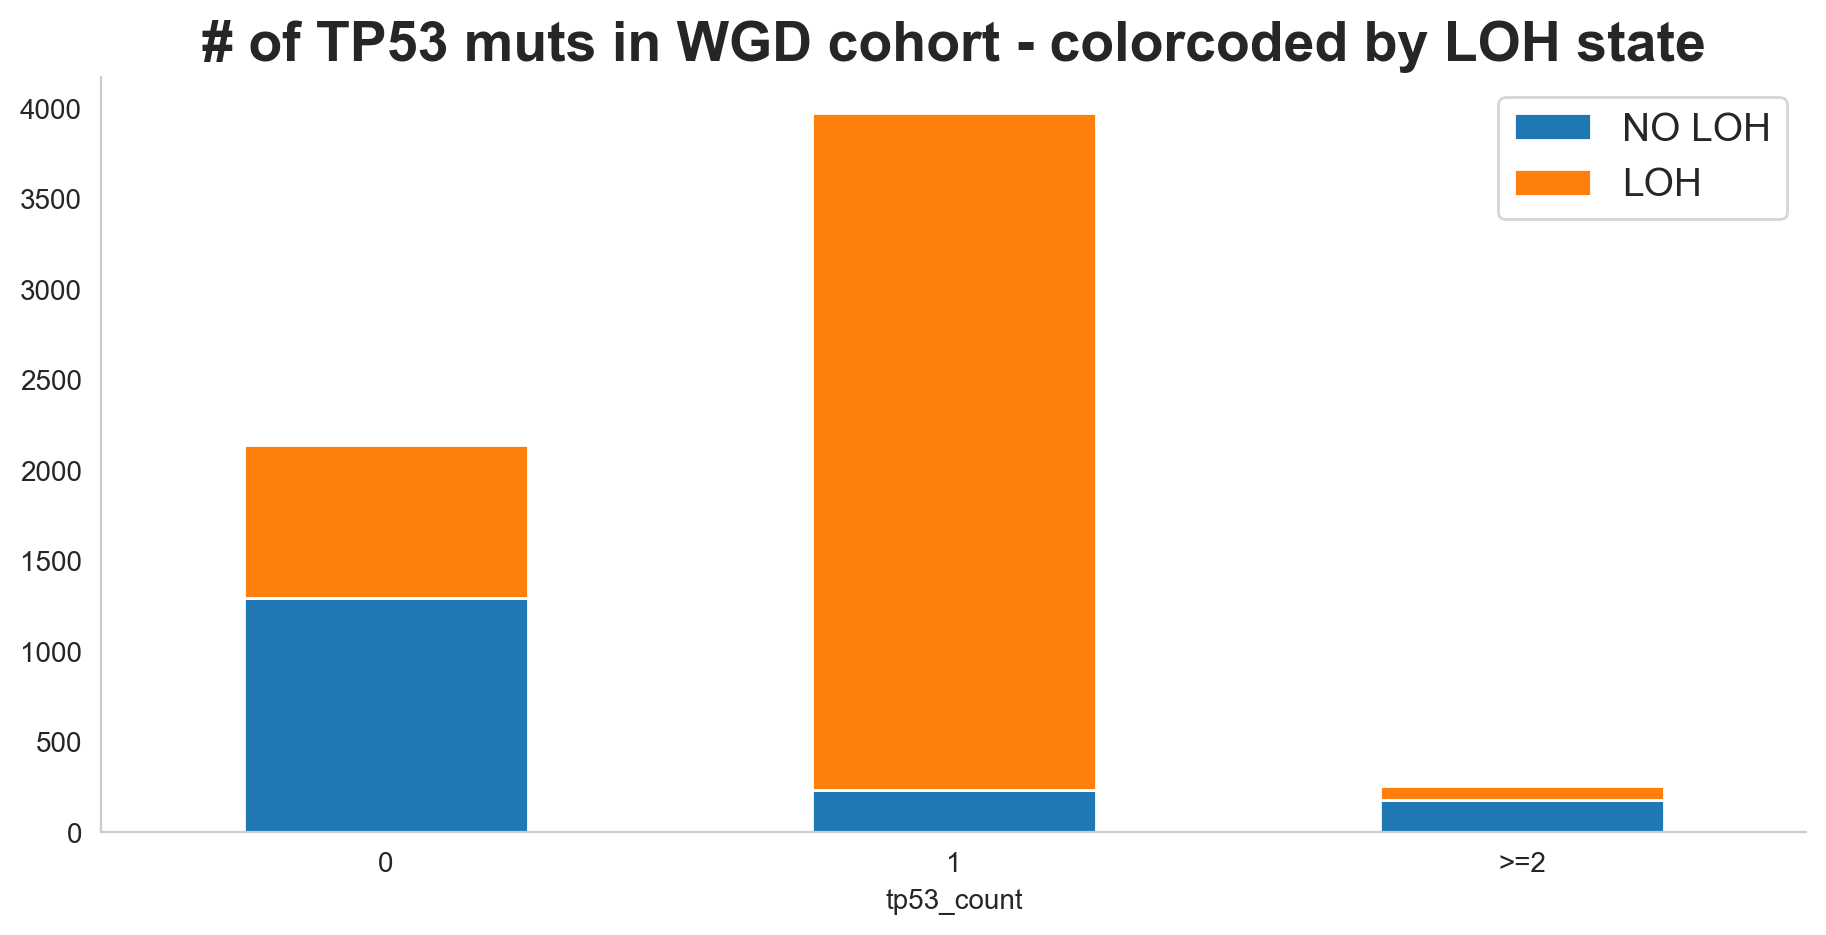

In [6]:
# First we need to groupby our cohort_wgd file to have the size of the different groups
loh_tp53count = pd.DataFrame(master_wgd[['tp53_count', 'tp53_loh_status']].groupby(['tp53_count', 'tp53_loh_status']).size()).unstack()
loh_tp53count = loh_tp53count.fillna(0)
loh_tp53count.columns=['NO LOH', 'LOH']
loh_tp53count.loc['>=2'] = [loh_tp53count['NO LOH'][2:].sum(),loh_tp53count['LOH'][2:].sum()]
loh_tp53count = loh_tp53count.drop([2,3,4,5],axis=0)
display(loh_tp53count)

sns.set_style("whitegrid", {'grid.color': '1.'})
fig = plt.figure(figsize=(11,5))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
h = loh_tp53count.plot(kind = 'bar', stacked=True, ax=ax)
ax.set_xticklabels(['0', '1','>=2'], rotation=0)
ax.legend(['NO LOH', 'LOH'], fontsize=14)
ax.set_title('# of TP53 muts in WGD cohort - colorcoded by LOH state',weight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

,CNLOH,LOSS,NO LOH
tp53_count,,,
0,161.0,684.0,1294.0
1,974.0,2764.0,235.0
>=2,24.0,52.0,179.0


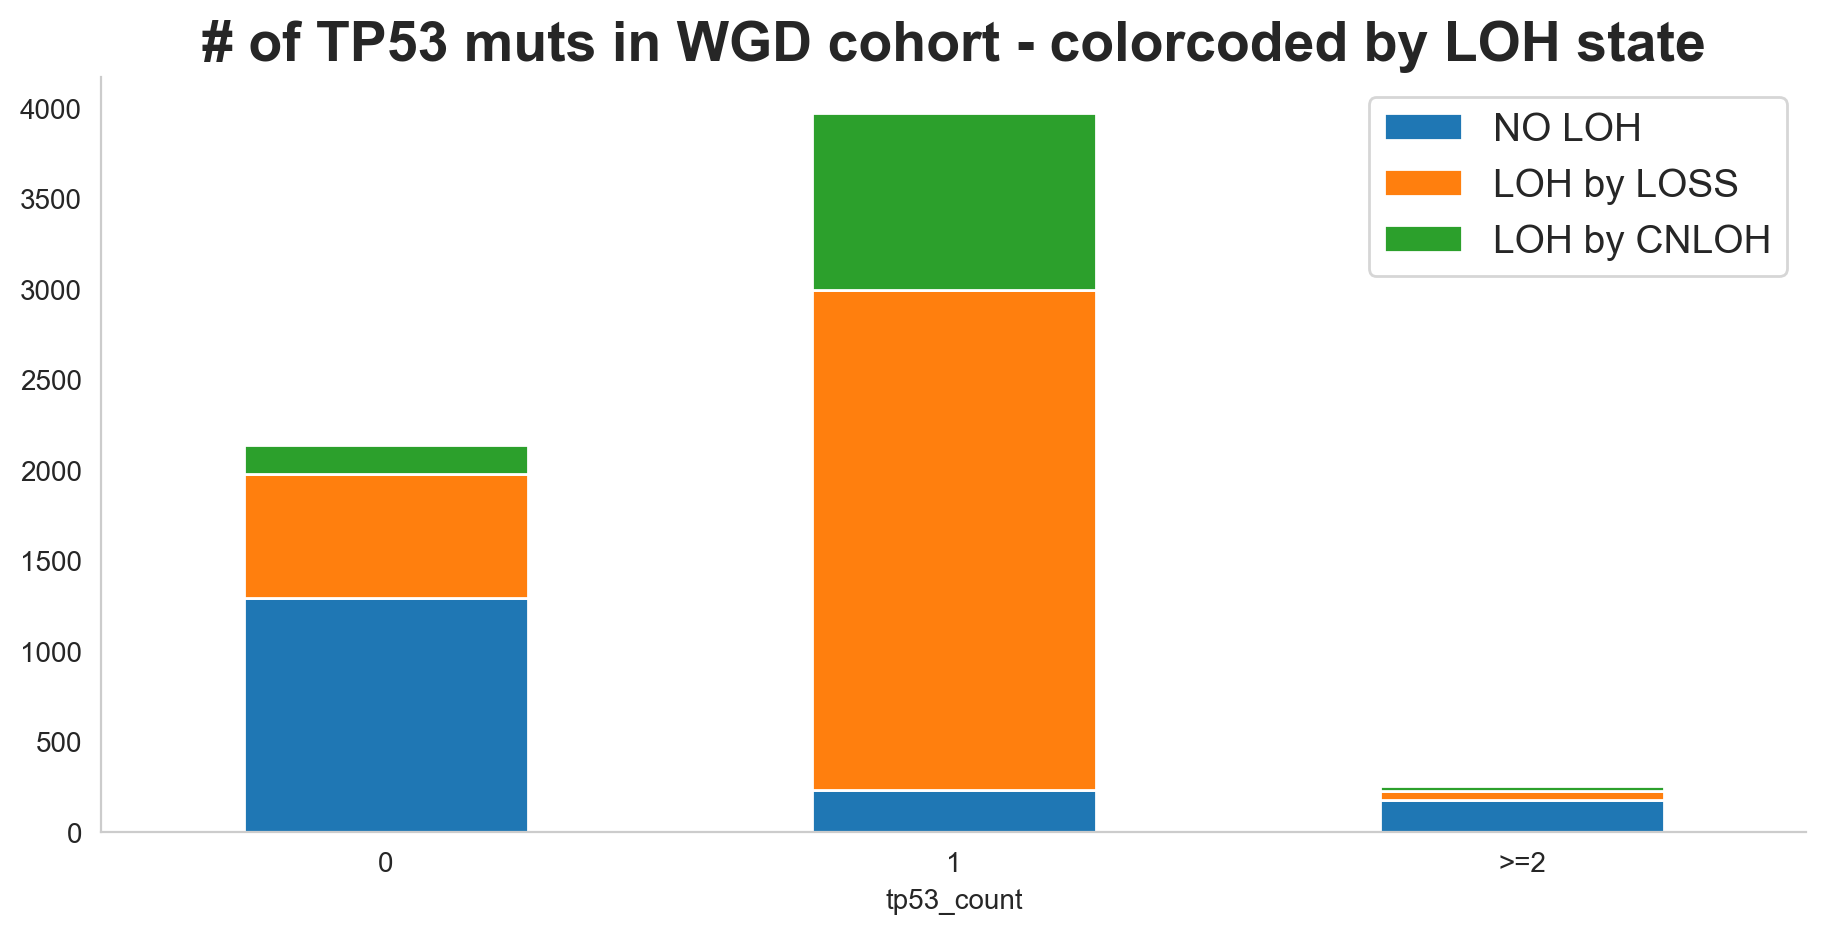

In [10]:
loh_tp53count = pd.DataFrame(master_wgd[['tp53_count', 'tp53_cn_state']].groupby(['tp53_count', 'tp53_cn_state']).size()).unstack()
loh_tp53count.columns = ['CNLOH AFTER', 'CNLOH BEFORE', 'CNLOH BEFORE & GAIN','CNLOH BEFORE & LOSS','DOUBLE LOSS AFTER', 'LOSS AFTER','LOSS BEFORE', 'TETRAPLOID']
loh_tp53count = loh_tp53count.fillna(0)

loh_tp53count['CNLOH'] = loh_tp53count[['CNLOH BEFORE & LOSS', 'CNLOH BEFORE', 'CNLOH BEFORE & GAIN']].sum(axis=1)
loh_tp53count['LOSS'] = loh_tp53count[['LOSS BEFORE']].sum(axis=1)
loh_tp53count['NO LOH'] = loh_tp53count[['TETRAPLOID', 'LOSS AFTER', 'DOUBLE LOSS AFTER', 'CNLOH AFTER']].sum(axis=1)
loh_tp53count.loc['>=2'] = loh_tp53count[2:].sum()
loh_tp53count = loh_tp53count.drop([2,3,4,5],axis=0)

display(loh_tp53count[['CNLOH', 'LOSS', 'NO LOH']])


sns.set_style("whitegrid", {'grid.color': '1.'})
fig = plt.figure(figsize=(11,5))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
h = loh_tp53count[[ 'NO LOH','LOSS', 'CNLOH']].plot(kind = 'bar', stacked=True, ax=ax)
ax.set_xticklabels(['0', '1','>=2'], rotation=0)
ax.legend(['NO LOH', 'LOH by LOSS', 'LOH by CNLOH'], fontsize=14)
ax.set_title('# of TP53 muts in WGD cohort - colorcoded by LOH state',weight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Merged Plot

## Cohort size

,CNLOH,LOSS,NO LOH
0|W,161.0,684.0,1294.0
1|W,974.0,2764.0,235.0
>=2|W,24.0,52.0,179.0


,CNLOH,LOSS,HOMDEL,NO LOH
0|NW,144.0,2431.0,96.0,7662.0
1|NW,692.0,3346.0,36.0,530.0
>=2|NW,23.0,119.0,7.0,429.0


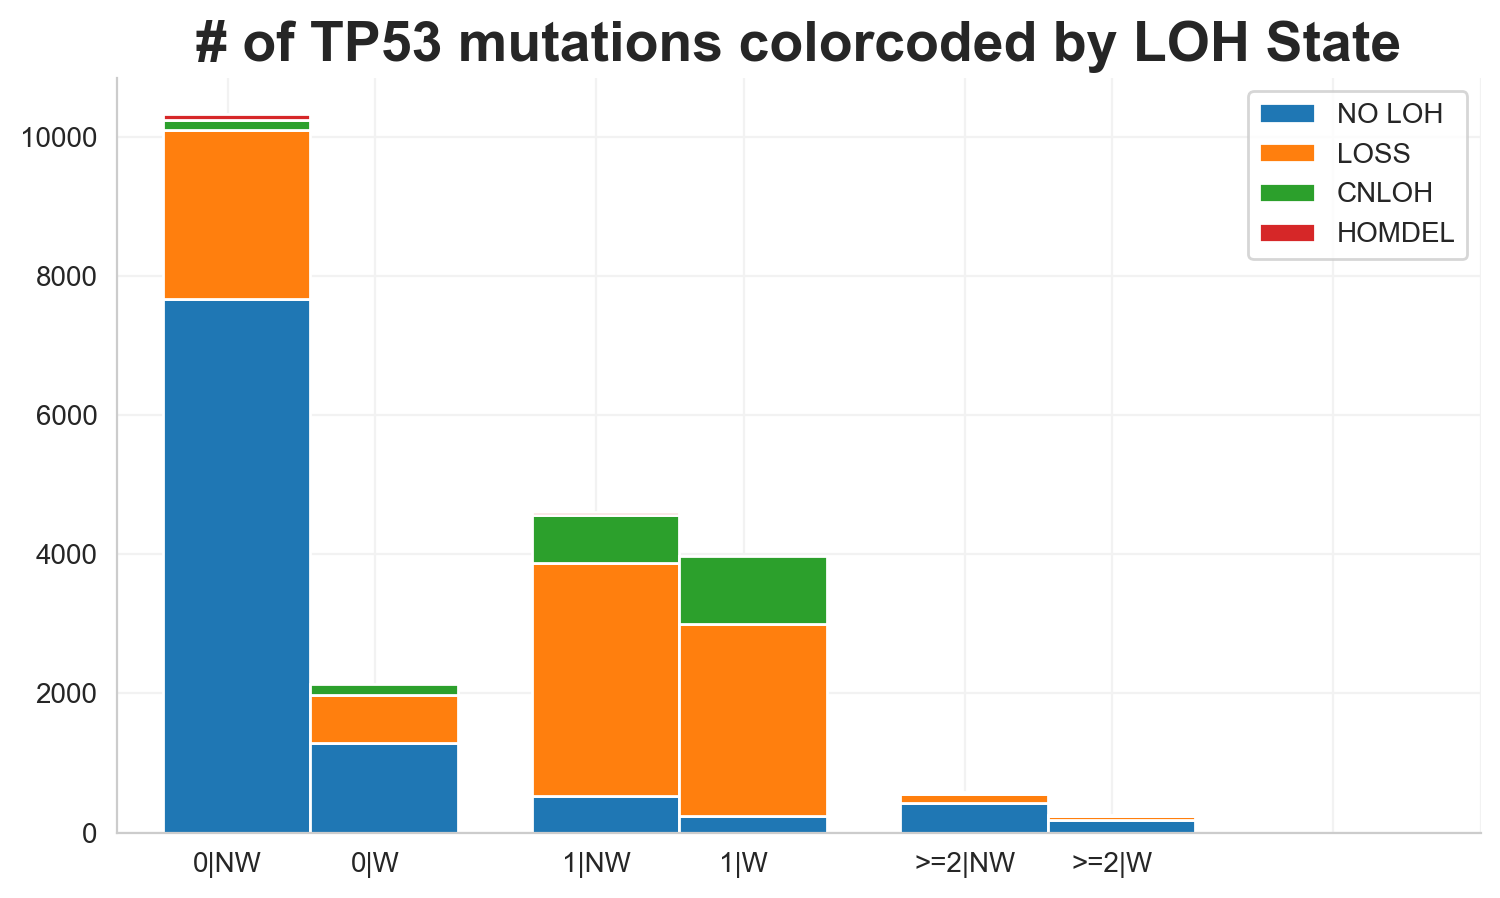

In [32]:
# WGD Count
loh_tp53count = pd.DataFrame(master_wgd[['tp53_count', 'tp53_cn_state']].groupby(['tp53_count', 'tp53_cn_state']).size()).unstack()
loh_tp53count.columns = ['CNLOH AFTER', 'CNLOH BEFORE', 'CNLOH BEFORE & GAIN','CNLOH BEFORE & LOSS','DOUBLE LOSS AFTER', 'LOSS AFTER','LOSS BEFORE', 'TETRAPLOID']
loh_tp53count = loh_tp53count.fillna(0)

loh_tp53count['CNLOH'] = loh_tp53count[['CNLOH BEFORE & LOSS', 'CNLOH BEFORE', 'CNLOH BEFORE & GAIN']].sum(axis=1)
loh_tp53count['LOSS'] = loh_tp53count[['LOSS BEFORE']].sum(axis=1)
loh_tp53count['NO LOH'] = loh_tp53count[['TETRAPLOID', 'LOSS AFTER', 'DOUBLE LOSS AFTER', 'CNLOH AFTER']].sum(axis=1)
loh_tp53count.loc['>=2'] = loh_tp53count[2:].sum()
loh_tp53count_wgd = loh_tp53count.drop([2,3,4,5],axis=0)
loh_tp53count_wgd.index = ['0|W', '1|W','>=2|W']

display(loh_tp53count_wgd[['CNLOH', 'LOSS', 'NO LOH']])

# Non WGD Count
loh_tp53count = pd.DataFrame(master[['tp53_count', 'tp53_cn_state']].groupby(['tp53_count', 'tp53_cn_state']).size()).unstack()
loh_tp53count.columns = ['AMP', 'AMP (BALANCED)', 'CNLOH', 'CNLOH & GAIN', 'DIPLOID', 'GAIN', 'HETLOSS', 'HOMDEL', 'TETRAPLOID']
loh_tp53count = loh_tp53count.fillna(0)

loh_tp53count['CNLOH'] = loh_tp53count[['CNLOH', 'CNLOH & GAIN']].sum(axis=1)
loh_tp53count['LOSS'] = loh_tp53count[['HETLOSS']].sum(axis=1)
loh_tp53count['HOMDEL'] = loh_tp53count[['HOMDEL']].sum(axis=1)
loh_tp53count['NO LOH'] = loh_tp53count[['AMP', 'AMP (BALANCED)', 'DIPLOID', 'GAIN', 'TETRAPLOID']].sum(axis=1)
loh_tp53count.loc['>=2'] = loh_tp53count[2:].sum()
loh_tp53count_nowgd = loh_tp53count.drop([2,3,4,5],axis=0)
loh_tp53count_nowgd.index = ['0|NW', '1|NW','>=2|NW']

display(loh_tp53count_nowgd[['CNLOH', 'LOSS', 'HOMDEL', 'NO LOH']])

count = pd.concat([loh_tp53count_nowgd, loh_tp53count_wgd], axis=0)
count= count.fillna(0)
count = count.reindex(['0|NW', '0|W','1|NW', '1|W', '>=2|NW' ,'>=2|W'])

count[['CNLOH', 'LOSS', 'HOMDEL', 'NO LOH']]


fig = plt.figure(figsize=(11,5))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
h = count[[ 'NO LOH','LOSS', 'CNLOH', 'HOMDEL']].plot(kind = 'bar', stacked=True, ax=ax)
h.set_xticklabels(['0|NW', '0|W','1|NW', '1|W', '>=2|NW' ,'>=2|W'], rotation=0)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.set_title('# of TP53 mutations colorcoded by LOH State',weight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(True)

palette_list_new = [mc[5],mc[4],mc[0],mc[3],mc[2], mc[1]]
for j,container in enumerate(ax.containers):
    for i, child in enumerate(container.get_children()):
        if i%2 == 1: child.set_x(child.get_x() - 0.2)
        child.set_width(0.8)

ax.set_xticks([0.1, 0.9, 2.1, 2.9, 4.1, 4.9, 6.1, 6.9])

plt.show()


## Proportions

,CNLOH,LOSS,NO LOH
0|W,0.025287,0.107429,0.203235
1|W,0.152976,0.434113,0.036909
>=2|W,0.003769,0.008167,0.028114


,CNLOH,LOSS,HOMDEL,NO LOH
0|NW,0.009281,0.156687,0.006188,0.493845
1|NW,0.044602,0.215662,0.002320,0.034160
>=2|NW,0.001482,0.007670,0.000451,0.027651


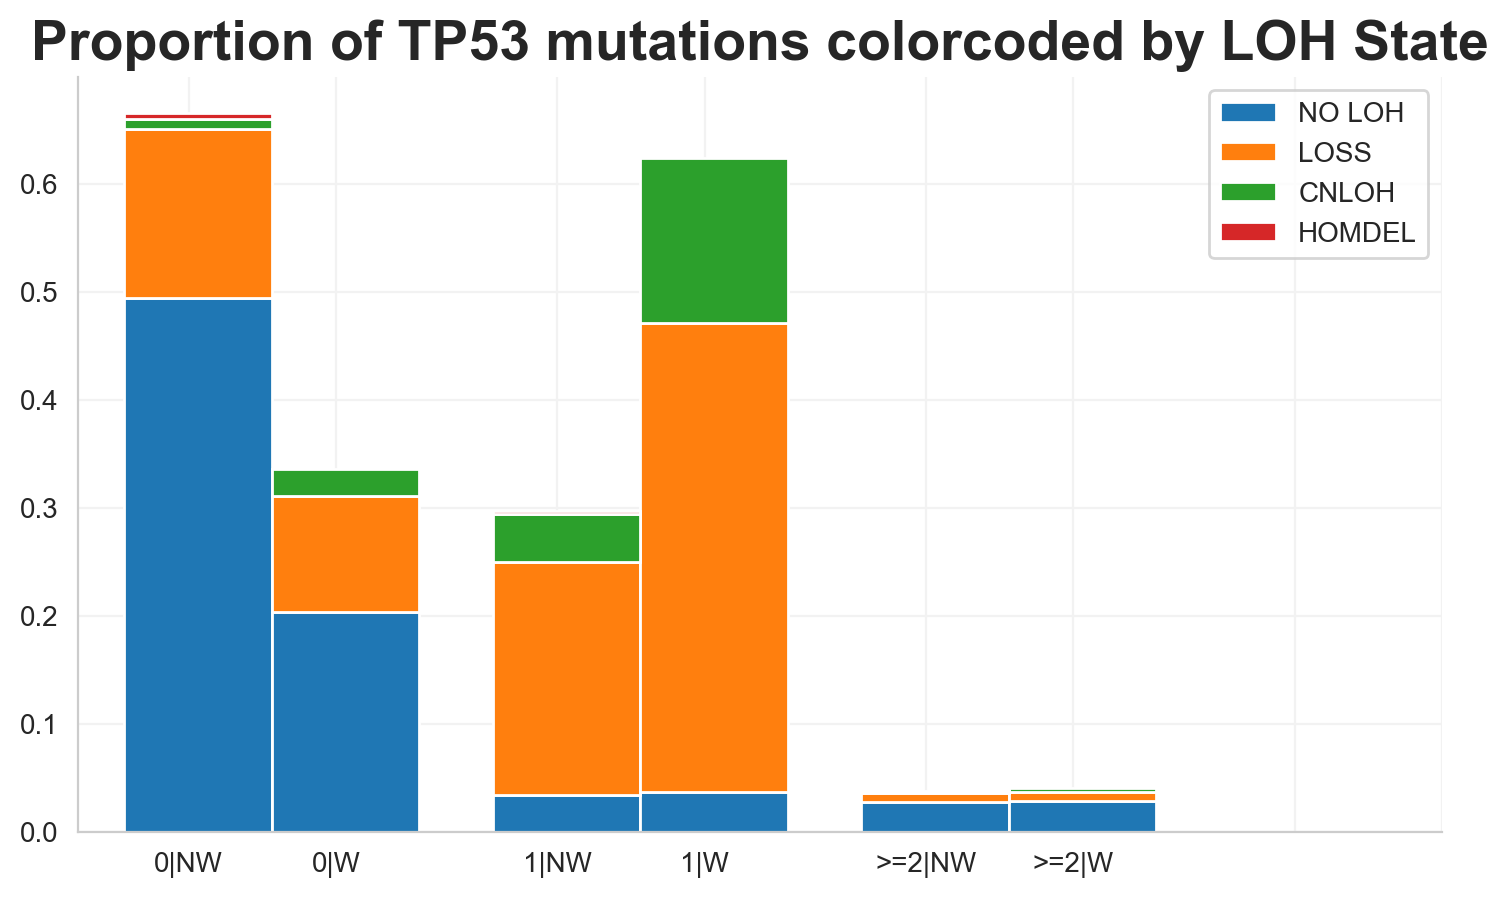

In [37]:
# WGD Count
loh_tp53count = pd.DataFrame(master_wgd[['tp53_count', 'tp53_cn_state']].groupby(['tp53_count', 'tp53_cn_state']).size()).unstack()
loh_tp53count.columns = ['CNLOH AFTER', 'CNLOH BEFORE', 'CNLOH BEFORE & GAIN','CNLOH BEFORE & LOSS','DOUBLE LOSS AFTER', 'LOSS AFTER','LOSS BEFORE', 'TETRAPLOID']
loh_tp53count = loh_tp53count.fillna(0)

loh_tp53count['CNLOH'] = loh_tp53count[['CNLOH BEFORE & LOSS', 'CNLOH BEFORE', 'CNLOH BEFORE & GAIN']].sum(axis=1)
loh_tp53count['LOSS'] = loh_tp53count[['LOSS BEFORE']].sum(axis=1)
loh_tp53count['NO LOH'] = loh_tp53count[['TETRAPLOID', 'LOSS AFTER', 'DOUBLE LOSS AFTER', 'CNLOH AFTER']].sum(axis=1)
loh_tp53count.loc['>=2'] = loh_tp53count[2:].sum()
loh_tp53count_wgd = loh_tp53count.drop([2,3,4,5],axis=0)
loh_tp53count_wgd.index = ['0|W', '1|W','>=2|W']
loh_tp53count_wgd = loh_tp53count_wgd[['CNLOH', 'LOSS', 'NO LOH']]
loh_tp53count_wgd = loh_tp53count_wgd / loh_tp53count_wgd.sum().sum()
#print(loh_tp53count_wgd.sum().sum())

display(loh_tp53count_wgd[['CNLOH', 'LOSS', 'NO LOH']])

# Non WGD Count
loh_tp53count = pd.DataFrame(master[['tp53_count', 'tp53_cn_state']].groupby(['tp53_count', 'tp53_cn_state']).size()).unstack()
loh_tp53count.columns = ['AMP', 'AMP (BALANCED)', 'CNLOH', 'CNLOH & GAIN', 'DIPLOID', 'GAIN', 'HETLOSS', 'HOMDEL', 'TETRAPLOID']
loh_tp53count = loh_tp53count.fillna(0)

loh_tp53count['CNLOH'] = loh_tp53count[['CNLOH', 'CNLOH & GAIN']].sum(axis=1)
loh_tp53count['LOSS'] = loh_tp53count[['HETLOSS']].sum(axis=1)
loh_tp53count['HOMDEL'] = loh_tp53count[['HOMDEL']].sum(axis=1)
loh_tp53count['NO LOH'] = loh_tp53count[['AMP', 'AMP (BALANCED)', 'DIPLOID', 'GAIN', 'TETRAPLOID']].sum(axis=1)
loh_tp53count.loc['>=2'] = loh_tp53count[2:].sum()
loh_tp53count_nowgd = loh_tp53count.drop([2,3,4,5],axis=0)
loh_tp53count_nowgd.index = ['0|NW', '1|NW','>=2|NW']
loh_tp53count_nowgd = loh_tp53count_nowgd[['CNLOH', 'LOSS', 'HOMDEL', 'NO LOH']]
loh_tp53count_nowgd = loh_tp53count_nowgd / loh_tp53count_nowgd.sum().sum()

display(loh_tp53count_nowgd[['CNLOH', 'LOSS', 'HOMDEL', 'NO LOH']])

count = pd.concat([loh_tp53count_nowgd, loh_tp53count_wgd], axis=0)
count= count.fillna(0)
count = count.reindex(['0|NW', '0|W','1|NW', '1|W', '>=2|NW' ,'>=2|W'])

count[['CNLOH', 'LOSS', 'HOMDEL', 'NO LOH']]


fig = plt.figure(figsize=(11,5))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
h = count[[ 'NO LOH','LOSS', 'CNLOH', 'HOMDEL']].plot(kind = 'bar', stacked=True, ax=ax)
h.set_xticklabels(['0|NW', '0|W','1|NW', '1|W', '>=2|NW' ,'>=2|W'], rotation=0)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.set_title('Proportion of TP53 mutations colorcoded by LOH State',weight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(True)

palette_list_new = [mc[5],mc[4],mc[0],mc[3],mc[2], mc[1]]
for j,container in enumerate(ax.containers):
    for i, child in enumerate(container.get_children()):
        if i%2 == 1: child.set_x(child.get_x() - 0.2)
        child.set_width(0.8)

ax.set_xticks([0.1, 0.9, 2.1, 2.9, 4.1, 4.9, 6.1, 6.9])

plt.show()



In [39]:
count

,CNLOH,LOSS,HOMDEL,NO LOH
0|NW,0.009281,0.156687,0.006188,0.493845
0|W,0.025287,0.107429,0.000000,0.203235
1|NW,0.044602,0.215662,0.002320,0.034160
1|W,0.152976,0.434113,0.000000,0.036909
>=2|NW,0.001482,0.007670,0.000451,0.027651
>=2|W,0.003769,0.008167,0.000000,0.028114


In [ ]:
def get_statistics(df: pd.DataFrame, group:str, metrics: str, group_list: list):
    group_1 = df[df[group] == group_list[0]][metrics]
    group_2 = df[df[group] == group_list[1]][metrics]

    median_1 = group_1.median()
    median_2 = group_2.median()

    statistic, p_value = ranksums(group_1.dropna().values,group_2.dropna().values)
    
    results = [['', 'size', metrics],
               [group_list[0], group_1.shape[0], median_1],
               [group_list[1], group_2.shape[0], median_2],
               ['', 'Statistics', 'p-value'],
               ['', statistic, p_value]]
    
    return pd.DataFrame(results)

get_statistics(df=master_no_wgd_cancer_wt,
               group='co_driver_group',
               metrics='frac_genome_altered',
               group_list=['High Co-Driver Count', 'Low Co-Driver Count'])

# Recompute Cancer and Metrics Panels
For that we use the scripts:
* *mskimpact_tp53_exploration/analysis/exploratory_analysis/cancer_analysis/cancer_panel.ipynb*
* *mskimpact_tp53_exploration/analysis/exploratory_analysis/metrics_analysis/metrics_panel.ipynb*

The panels are stored in:
*
*

In [72]:
get_groupby(master, 'tp53_lcn', 'count').sort_values(by='count', ascending=False)

,count
tp53_lcn,
1.0,10011
0.0,7761
2.0,69
3.0,5


In [80]:
set(list(master[master['tp53_lcn'] == 0]['tp53_cn_state']))

{'AMP (LOH)', 'CNLOH', 'CNLOH & GAIN', 'HETLOSS', 'HOMDEL'}

In [43]:
get_groupby(master_wgd, 'tp53_cn_state', 'count')

,count
tp53_cn_state,
CNLOH AFTER,59
CNLOH BEFORE,180
CNLOH BEFORE & GAIN,31
CNLOH BEFORE & LOSS,948
DOUBLE LOSS AFTER,433
LOSS AFTER,873
LOSS BEFORE,3500
TETRAPLOID,343
